# NBN Measuring Broadband Australia (MBA) - Broadband Performance Benchmark
Analysis of ACCC NBN MBA (Sept 2025) by RSP & access technology. This notebook produces KPIs, clean visuals, and CSV exports suitable for a Power BI dashboard.


Step 1 - Load the dataset
Upload the public MBA CSV (mba-report-30-data-release-september-2025.csv) from data.gov.au and preview the first rows to confirm columns and data types.


In [2]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
csv_name = next(iter(uploaded.keys()))
df = pd.read_csv(csv_name)

df.head()


Saving mba-report-30-data-release-september-2025.csv to mba-report-30-data-release-september-2025.csv


,unit_id,connection_type,technology,tier,rsp,state_or_territory,geography,is_this_service_impaired,is_this_service_underperforming,gateway_mac,...,Busy hour trimmed mean upload speed,Busy hour minimum upload speed,Busy hour maximum upload speed,All hour trimmed mean latency,All hour minimum latency,All hour maximum latency,Busy hour trimmed mean latency,Busy hour minimum latency,Busy hour maximum latency,Average daily outages
0,1027866,NBN,Hybrid Fibre Coaxial,100/40 Mbps,Other RSPs,NSW,Urban,False,False,7c:4xxxxxx,...,19.05,18.77,19.21,9.65,8.63,11.31,9.62,8.65,10.63,0.16
1,1027902,NBN,Fibre to the Node,100/20 Mbps,Optus,NSW,Urban,True,True,3c:5xxxxxx,...,18.60,18.40,18.72,18.68,14.58,46.63,18.79,15.76,22.58,0.23
2,1027904,NBN,Fibre to the Premises,250/25 Mbps,iiNet,TAS,Major Rural,False,False,2c:3xxxxxx,...,23.79,23.60,23.84,14.19,12.74,14.41,14.11,12.74,14.32,0.00
3,1028696,NBN,Fibre to the Premises,50/20 Mbps,Aussie Broadband,VIC,Urban,False,False,cc:fxxxxxx,...,17.70,11.98,19.25,2.14,1.89,2.68,2.13,1.89,2.68,0.03
4,1028732,NBN,Fibre to the Node,100/20 Mbps,Dodo & iPrimus,VIC,Minor Rural,False,False,60:1xxxxxx,...,18.56,17.68,18.88,17.23,12.71,56.14,18.10,13.64,56.14,0.06


Step 2 - Clean & sanity check
Standardise key text columns we will group by, and verify that the main numeric fields exist and are numeric.


In [3]:
df["rsp"] = df["rsp"].fillna("Unknown").str.strip()
df["technology"] = df["technology"].str.strip()

needed = [
    "Busy hour trimmed mean download speed",
    "Busy hour trimmed mean upload speed",
    "Busy hour trimmed mean latency",
    "Average daily outages",
    "is_this_service_underperforming",
]
df[needed].describe()

,Busy hour trimmed mean download speed,Busy hour trimmed mean upload speed,Busy hour trimmed mean latency,Average daily outages
count,1795.000000,1794.000000,1797.000000,1797.000000
mean,262.807476,25.046717,31.551558,0.291469
std,320.608676,14.592196,109.072478,2.964155
min,6.530000,0.570000,1.240000,0.000000
25%,53.675000,18.380000,4.370000,0.000000
50%,106.660000,18.920000,8.920000,0.030000
75%,268.855000,37.547500,16.410000,0.130000
max,943.790000,103.110000,734.800000,117.390000


Step 3 - Visual style
Apply a consistent, professional matplotlib style so all charts share the same look (font sizes, background, grid).


In [11]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-muted")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.facecolor": "whitesmoke",
    "grid.alpha": 0.3,
})

def label_bars(ax, fmt="{:.0f}"):
    """Put value labels on bars for readability."""
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, padding=3, fontsize=9)

Step 4 - Calculate KPIs
Compute five core indicators used throughout the report (busy-hour download/upload, latency, daily outages, and underperforming rate).


In [9]:
import numpy as np

kpis = {
    "Avg Busy Hour Download (Mbps)": round(df["Busy hour trimmed mean download speed"].mean(), 2),
    "Avg Busy Hour Upload (Mbps)":   round(df["Busy hour trimmed mean upload speed"].mean(), 2),
    "Avg Busy Hour Latency (ms)":    round(df["Busy hour trimmed mean latency"].mean(), 2),
    "Avg Daily Outages":             round(df["Average daily outages"].mean(), 3),
    "Underperforming Rate (%)":      round(df["is_this_service_underperforming"].mean() * 100, 2),
}
kpis

{'Avg Busy Hour Download (Mbps)': np.float64(262.81),
 'Avg Busy Hour Upload (Mbps)': np.float64(25.05),
 'Avg Busy Hour Latency (ms)': np.float64(31.55),
 'Avg Daily Outages': np.float64(0.291),
 'Underperforming Rate (%)': np.float64(4.51)}

Step 5 - RSP Performance Analysis
This section compares average busy-hour speeds and reliability across retail service providers (RSPs).  
We create a summary table and a professional horizontal bar chart showing the **Top 10 RSPs** ranked by busy-hour download speed.


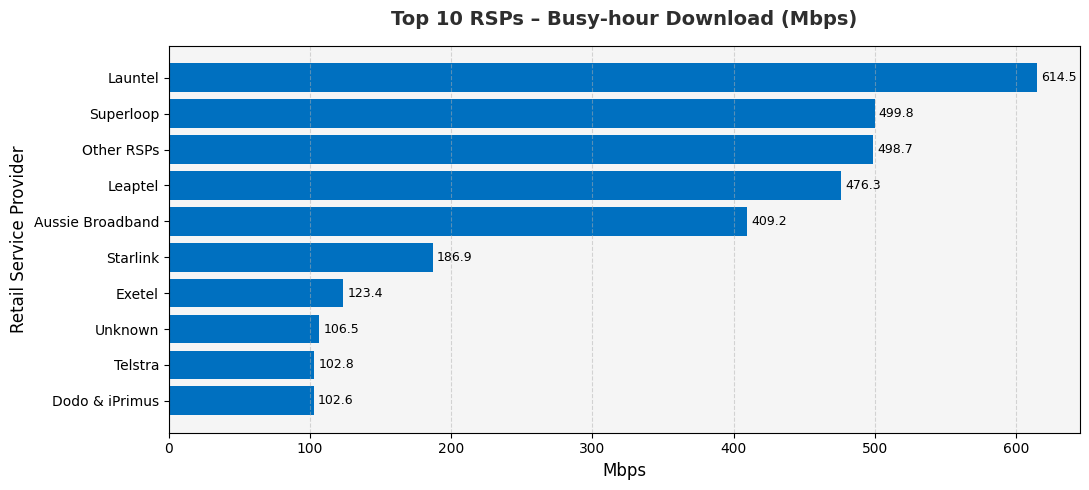

In [15]:
# ----- summarise by RSP -----
rsp_summary = (
    df.groupby("rsp")[["Busy hour trimmed mean download speed",
                       "Busy hour trimmed mean upload speed",
                       "Busy hour trimmed mean latency",
                       "Average daily outages"]]
      .mean()
      .sort_values("Busy hour trimmed mean download speed", ascending=False)
      .round(2)
)

top10 = rsp_summary.head(10).reset_index()

# ----- plot -----
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.barh(top10["rsp"], top10["Busy hour trimmed mean download speed"], color="#0070C0")
ax.invert_yaxis()
ax.set_title("Top 10 RSPs – Busy-hour Download (Mbps)", pad=15, fontweight="bold", color="#2E2E2E")
ax.set_xlabel("Mbps")
ax.set_ylabel("Retail Service Provider")
ax.grid(axis="x", linestyle="--", alpha=0.5)

# add value labels
for i, v in enumerate(top10["Busy hour trimmed mean download speed"]):
    ax.text(v + 3, i, f"{v:.1f}", va="center", fontsize=9)

plt.tight_layout()
plt.show()

Step 6 - Technology Performance Comparison
This section analyses performance by **access technology** (FTTP, FTTN, HFC, FTTC, Fixed Wireless etc.).  
We examine how download speed and latency differ across each technology type.  
Charts are designed to highlight clear throughput and responsiveness differences.


In [16]:
# ----- summarise by technology -----
tech_summary = (
    df.groupby("technology")[["Busy hour trimmed mean download speed",
                              "Busy hour trimmed mean upload speed",
                              "Busy hour trimmed mean latency",
                              "Average daily outages"]]
      .mean()
      .sort_values("Busy hour trimmed mean download speed", ascending=False)
      .round(2)
)
tech_summary

,Busy hour trimmed mean download speed,Busy hour trimmed mean upload speed,Busy hour trimmed mean latency,Average daily outages
technology,,,,
Fibre to the Premises,349.82,29.84,7.06,0.33
Hybrid Fibre Coaxial,338.75,28.89,10.62,0.26
Fixed Wireless,123.62,11.08,45.26,0.16
Satellite,116.91,19.91,333.16,0.36
Fibre to the Curb,72.93,19.20,7.18,0.38
Fibre to the Node,55.71,15.70,15.47,0.24


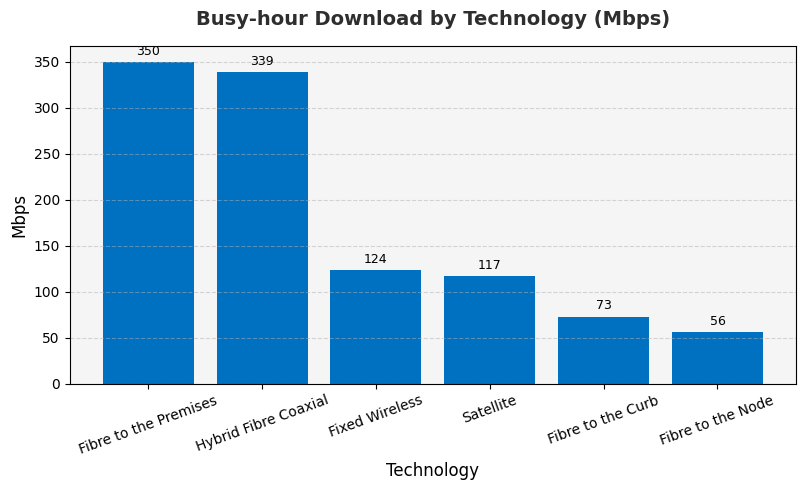

In [17]:
fig, ax = plt.subplots(figsize=(8.5, 5))
bars = ax.bar(tech_summary.index,
               tech_summary["Busy hour trimmed mean download speed"],
               color="#0070C0")
ax.set_title("Busy-hour Download by Technology (Mbps)", pad=15, fontweight="bold", color="#2E2E2E")
ax.set_xlabel("Technology")
ax.set_ylabel("Mbps")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)
label_bars(ax)
plt.tight_layout(rect=[0, 0, 0.96, 1])
plt.show()

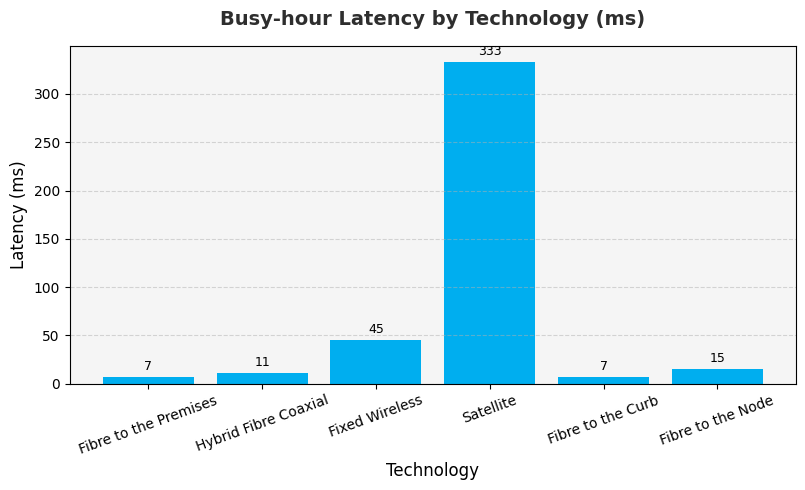

In [18]:
fig, ax = plt.subplots(figsize=(8.5, 5))
bars = ax.bar(tech_summary.index,
               tech_summary["Busy hour trimmed mean latency"],
               color="#00AEEF")
ax.set_title("Busy-hour Latency by Technology (ms)", pad=15, fontweight="bold", color="#2E2E2E")
ax.set_xlabel("Technology")
ax.set_ylabel("Latency (ms)")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)
label_bars(ax)
plt.tight_layout(rect=[0, 0, 0.96, 1])
plt.show()

Step 7 - Network Health - Underperforming & Impaired
A service is **underperforming** if it persistently fails to reach acceptable speed thresholds.
A service is **impaired** if stability is degraded (e.g., high loss/jitter/outages).

We calculate the share (%) by **technology** to help prioritise upgrades (e.g., FTTN → FTTP).


In [19]:
# Compute health metrics by technology
health = (
    df.groupby("technology")
      .agg(
          underperf_pct=("is_this_service_underperforming", lambda s: 100 * s.mean()),
          avg_latency=("Busy hour trimmed mean latency", "mean"),
          avg_outages=("Average daily outages", "mean")
      )
      .round({"underperf_pct": 2, "avg_latency": 2, "avg_outages": 3})
      .sort_values("underperf_pct", ascending=False)
      .reset_index()
)

if "is_this_service_impaired" in df.columns:
    tmp = df.groupby("technology")["is_this_service_impaired"].mean().mul(100).round(2).reset_index(name="impaired_pct")
    health = health.merge(tmp, on="technology", how="left")
else:
    health["impaired_pct"] = None

health

,technology,underperf_pct,avg_latency,avg_outages,impaired_pct
0,Fixed Wireless,17.88,45.26,0.163,0.00
1,Fibre to the Node,11.36,15.47,0.238,16.85
2,Fibre to the Premises,1.92,7.06,0.333,0.00
3,Hybrid Fibre Coaxial,1.56,10.62,0.261,0.00
4,Satellite,0.94,333.16,0.360,0.00
5,Fibre to the Curb,0.00,7.18,0.378,0.00


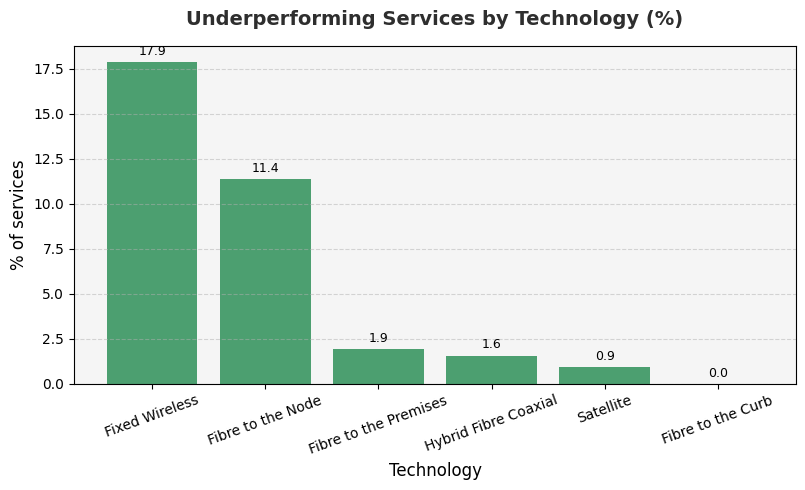

In [20]:
# Plot underperforming % by technology
fig, ax = plt.subplots(figsize=(8.5, 5))
bars = ax.bar(health["technology"], health["underperf_pct"], color="#4C9F70")
ax.set_title("Underperforming Services by Technology (%)", pad=15, fontweight="bold", color="#2E2E2E")
ax.set_xlabel("Technology"); ax.set_ylabel("% of services")
ax.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=20)
label_bars(ax, fmt="{:.1f}")
plt.tight_layout(rect=[0, 0, 0.96, 1])
plt.show()

Step 8 - Export Clean Tables
Export tidy CSVs for reuse in Power BI or Tableau.  

| File | Description |
|-------|--------------|
| `kpis.csv` | Overall national KPI summary |
| `rsp_summary.csv` | Average performance by Retail Service Provider |
| `tech_summary.csv` | Average performance by access technology |
| `network_health_by_tech.csv` | Underperforming % and latency by technology |

In [21]:
import os

os.makedirs("exports", exist_ok=True)

# Save each table
pd.DataFrame([kpis]).to_csv("exports/kpis.csv", index=False)
rsp_summary.to_csv("exports/rsp_summary.csv")
tech_summary.to_csv("exports/tech_summary.csv")
health.to_csv("exports/network_health_by_tech.csv", index=False)

print("✅ Saved to /export folder — ready for Power BI or GitHub upload")

✅ Saved to /export folder — ready for Power BI or GitHub upload


In [22]:
from google.colab import files
for f in os.listdir("exports"):
    files.download(f"exports/{f}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 9 - Summary Dashboard Image
Create a 2x2 “mini dashboard” showing:
#1 Top 10 RSPs - Busy-hour Download  
#2️ Download by Technology  
#3️ Latency by Technology  
#4 Underperforming % by Technology  

✅ Saved: figs/summary_dashboard.png


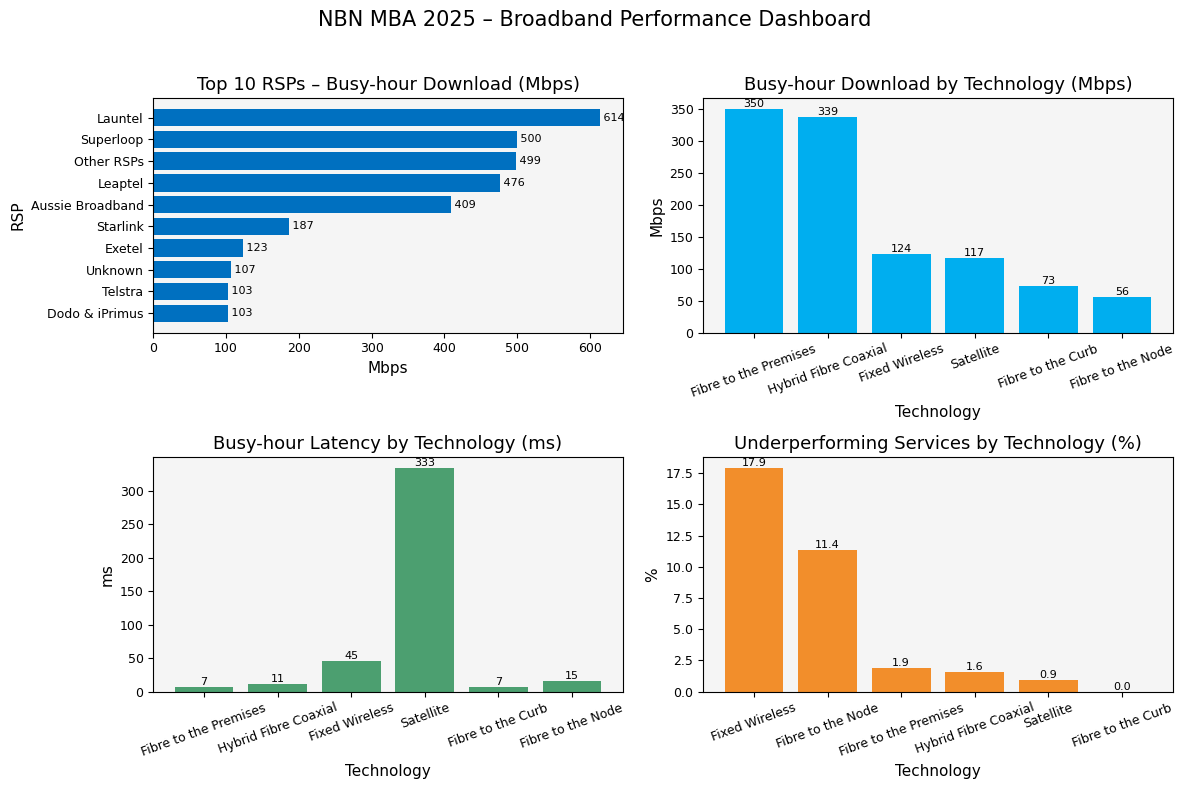

In [24]:
import matplotlib.pyplot as plt
import os

# --- figure style ---
plt.rcParams.update({
    "figure.figsize": (12, 8),
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
})

fig, axes = plt.subplots(2, 2)
fig.suptitle("NBN MBA 2025 – Broadband Performance Dashboard", fontsize=15, y=0.98)

# --- (1) Top 10 RSPs ---
ax = axes[0,0]
ax.barh(top10["rsp"], top10["Busy hour trimmed mean download speed"], color="#0070C0")
ax.invert_yaxis()
ax.set_title("Top 10 RSPs – Busy-hour Download (Mbps)")
ax.set_xlabel("Mbps"); ax.set_ylabel("RSP")
for i, v in enumerate(top10["Busy hour trimmed mean download speed"]):
    ax.text(v, i, f" {v:.0f}", va="center", fontsize=8)

# --- (2) Download by Technology ---
ax = axes[0,1]
ax.bar(tech_summary.index, tech_summary["Busy hour trimmed mean download speed"], color="#00AEEF")
ax.set_title("Busy-hour Download by Technology (Mbps)")
ax.set_xlabel("Technology"); ax.set_ylabel("Mbps")
ax.tick_params(axis="x", rotation=20)
for i, v in enumerate(tech_summary["Busy hour trimmed mean download speed"]):
    ax.text(i, v, f"{v:.0f}", ha="center", va="bottom", fontsize=8)

# --- (3) Latency by Technology ---
ax = axes[1,0]
ax.bar(tech_summary.index, tech_summary["Busy hour trimmed mean latency"], color="#4C9F70")
ax.set_title("Busy-hour Latency by Technology (ms)")
ax.set_xlabel("Technology"); ax.set_ylabel("ms")
ax.tick_params(axis="x", rotation=20)
for i, v in enumerate(tech_summary["Busy hour trimmed mean latency"]):
    ax.text(i, v, f"{v:.0f}", ha="center", va="bottom", fontsize=8)

# --- (4) Underperforming % by Technology ---
ax = axes[1,1]
ax.bar(health["technology"], health["underperf_pct"], color="#F28E2B")
ax.set_title("Underperforming Services by Technology (%)")
ax.set_xlabel("Technology"); ax.set_ylabel("%")
ax.tick_params(axis="x", rotation=20)
for i, v in enumerate(health["underperf_pct"]):
    ax.text(i, v, f"{v:.1f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.96])
os.makedirs("figs", exist_ok=True)
plt.savefig("figs/summary_dashboard.png", dpi=150)
print("✅ Saved: figs/summary_dashboard.png")
plt.show()

In [25]:
from google.colab import files
files.download("figs/summary_dashboard.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>